# CT reconstruction via spectral decomposition of the atomic structure

First we load the atomic structure and the MD trajectory in order to generate the synthetic dataset.
For the atomic model in each frame we select the C-$\alpha$ positions.

In [1]:
import torch
import numpy as np
import mdtraj as md

## We load an MD trajectory.
## The molecular structure must be in a pdb or psf file.
## The trajectory is stored in a dcd file.

struct = 2 # 1 for the small protein (214 C-alpha atoms) and 2 for the big one (590 C-alpha atoms).

if struct == 1:
    MD_traj = md.load('data/struct1/dims0001_fit-core.dcd',top = 'data/struct1/adk4ake.psf')
    view_angle_plot = torch.tensor([[0, 0, 0]])
if struct == 2:
    MD_traj = md.load('data/struct2/MD_traj2_short.dcd',top = 'data/struct2/DESRES-Trajectory_sarscov2-12212688-5-2-no-water.pdb')
    view_angle_plot = torch.tensor([[-1.57, .2, 1.2]])


## Here we select the C-alpha positions
indices = []
for m in MD_traj.topology.atoms_by_name('CA'):
    indices.append(m.index)

# We have to multily the trajectory by 10 so that the interatomic distance is in Angstroms
CA_pos = torch.tensor(MD_traj.xyz[:,indices,:])*10 
print('Average interatomic distance:',round(float((CA_pos[:,1:]-CA_pos[:,:-1]).norm(dim=-1).mean()),2), 'Angstroms')

Average interatomic distance: 3.85 Angstroms


## Parameters of the MD trajectory

Now we compute the parameters of each atomic model in the MD trajectory (rotation angles, orientation and location).
This will serve as ground truth.

In [2]:
## We set the reference atom. In this case, we select the atom which is most
# centred in the structure.

D = torch.zeros(CA_pos.shape[1])

for i in range(CA_pos.shape[1]):
    D[i] = (CA_pos[0] - CA_pos[0,i]).sum(dim=0).norm()

ref_idx = torch.argmin(D)

## We now compute the parameters for each of the chains in the MD trajectory
## These parameters represent the groud truth.

from tools.DFF import compute_parameters

Psi, Theta, x0s, Orientations, Dists = compute_parameters(CA_pos, ref_idx)

from data_generator.structure_batch import chain_structure

# We create a chain structure for the MD trajectory. This one will be used to generate the synthetic dataset.
trajectory_ground_truth = chain_structure(Psi, Theta, x0s, Orientations, Dists, ref_idx)

## We select the indexes that are to be estimated (those which may vary depending on the conformation).
## Since we do not have prior information about secondary structures, we select all the angles.
idx_model = list(range(Psi.shape[1]))

### Synthetic cryo-EM data

We generate the synthetic cryo-EM dataset. We need to specify the features of the dataset such as the CTF parameters and noise levels.

For each cryo-EM image, the defocus of the CTF is chosen at random among the values in the vector 'Df'.

$$
CTF(k, \lambda, \Delta f, C_s) = \left( \sqrt{1-\alpha^2}  \cos( \theta (k) ) - \alpha \sin( \theta (k) )   \right) \exp \left(-\frac{B|k|}{4} \right) 
$$
with
$$
\theta (k) :=2\pi \left( - \dfrac{\Delta f \lambda |k|^2}{2} + \dfrac{C_s \lambda^3 |k|^4}{4} \right) + \theta_0
\quad \text{for} \ k \in \left\{ \left(\frac{i}{2L},\frac{j}{2L}\right), \quad (i,j) \in [-n_{px}, \ldots , n_{px}-1]^2  \right\} 
$$
where $\Delta f$ is the defocus in Angstroms, e.g. $2.5\cdot 10^4$, $L$ is the length of the image side in Angstroms and $n_{px}$ is the number of pixels of the image side.

The wavelength $\lambda$ in terms of the voltage $V$ in KeV:
$$
\lambda = \dfrac{h}{\sqrt{2 m_0 E \left( 1+ \frac{E}{2m_0 c^2}\right)}} = \dfrac{12.2643247}{\sqrt{V\cdot 10^3 + 0.978466V^2}}.
$$ 

/Users/carlosesteveyague/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 400/400 [00:04<00:00, 81.93it/s]


Pixel size: 1.7


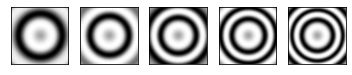

In [3]:
### Here we generate the dataset

from data_generator.dataset import dataset

CTF_data_feat = {
        'kV' : 200, # voltage in KV
        'Df' : torch.tensor([1.5, 1.75, 2., 2.25, 2.5]), # List of Defocus values in microns
        'Cs' : 2., # Spherical aberration in milimeters
        'alpha' : .1, # amplitude constrast 
        'B_factor' : 0., # Decay factor in Angstroms
        'phase_shift': 0. # Degrees
        }

dataset_features = {
        'struct' : trajectory_ground_truth,
        'n_imgs' : 400,
        'orient_variability' : torch.Tensor([[0,2*np.pi], 
                                             [0,2*np.pi], 
                                             [0,2*np.pi]]),
        'n_px_3d' : 16,
        'sigma_gaussian_3d' : 3.,
        'mask_size_3d' : 5, # voxels
        'noise_3d' : .5,
        
        'n_px_2d' : 64,
        'noise_2d' : 3.,
        'density_type': 'Gaussian',
        'sigma_density' : 3.,
        
        'CTF_data_feat' : CTF_data_feat
        }


(vols_data, structure_data, orientation_diffs_data, 
 CT_images_noise, CT_images_clean, clean_imgs_no_CTF, 
 img_lims, Df) = dataset(dataset_features)

# Let's display the CTF filters
from tools.CTF import CTF_filters

img_side = img_lims[0]-img_lims[1]

print('Pixel size:', round(float(img_side/dataset_features['n_px_2d']), 2))

filters = CTF_filters(dataset_features['n_px_2d'], img_side, CTF_data_feat['kV'], CTF_data_feat['Df'], CTF_data_feat['Cs'], 
                      CTF_data_feat['alpha'], CTF_data_feat['B_factor'], CTF_data_feat['phase_shift'])

from tools.plots import disp_image
disp_image(filters, multi_img = True)


### Examples of synthetic cryo-EM images

First row after applying the X-ray transform to the particle.
Second row after convolving with the CTF
Third row after adding gaussian noise

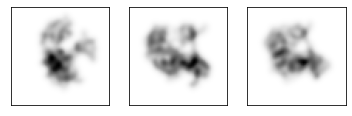

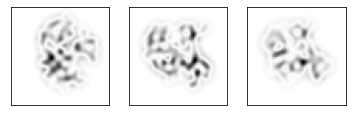

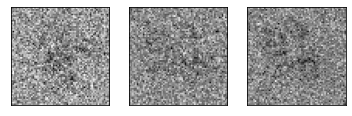

Signal to noise ratio: 0.0829


In [4]:
# Let's display some images
imgs = clean_imgs_no_CTF[:3]
disp_image(imgs, multi_img = True)

imgs = CT_images_clean[:3]
disp_image(imgs, multi_img = True)

imgs = CT_images_noise[:3]
disp_image(imgs, multi_img = True)


## Signal to Noise Ratio (SNR)
print('Signal to noise ratio:', round(float(CT_images_clean.var()/dataset_features['noise_2d']**2), 4))

## Construct the model

Here we construct the model to make the predictions. We need to select the given conformation, which will be used as initialization, the number of eigenvectors in the spectral decomposition. We also need to specify the features of the images such as dimensions and CTF parameters.

In [5]:
# As given conformation we take the first structure in the MD trajectory
n_init = 0 
Psi_init = trajectory_ground_truth.Psi[n_init]
Theta_init = trajectory_ground_truth.Theta[n_init]
ref_idx = trajectory_ground_truth.ref_idx

# The interatomic distance is set to be constant 
# and equal to the average interatomic distance
# in the given conformation.
dists = trajectory_ground_truth.dists[n_init]
dists = dists*0 + dists.mean()

# We specify the number of eigenvectors for the spectral decomposition.
n_eigenval = 10

model_features = {
        'n_eigenval' : n_eigenval,
        
        # Given atomic model
        'Psi_init' : Psi_init,
        'Theta_init' : Theta_init,
        'dists' : dists,
        'ref_idx': ref_idx,
        
        # Features of the images
        'img_lims': img_lims, 
        'n_px': CT_images_noise.shape[-1],
        'sigma_density' : dataset_features['sigma_density'], # sigma of the Gaussian density for each atom
        'density_type' : dataset_features['density_type'],        
        'CTF_feat' : CTF_data_feat,
        
        # List of indexes to be estimated
        'param_idxs' : idx_model
        
        }

from model.model_chain import model_chain

model = model_chain(model_features)

## Graph Laplacian

Time to compute the graph Laplacian: 0.1880190372467041
Time to compute the eigenvectors: 0.05762195587158203


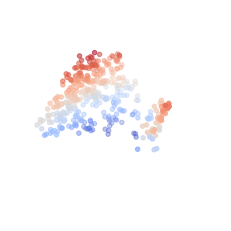

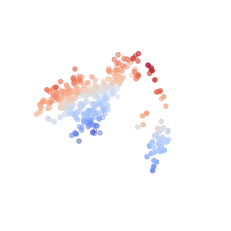

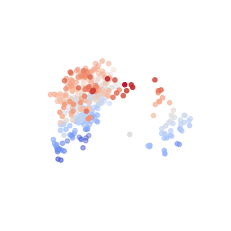

In [6]:
from time import time
from tools.graph import graph_gaussian_kernel, laplacian, eigen_graph

sigma_gauss_kernel = 5*dataset_features['n_px_3d']*dataset_features['noise_3d']

start = time()
graph = graph_gaussian_kernel(vols_data, sigma_gauss_kernel).detach()
print('Time to compute the graph Laplacian:', time() - start)

start = time()
Lap = laplacian(graph, True)
[eigen_val, eigen_vec] = eigen_graph(Lap, n_eigenval)
print('Time to compute the eigenvectors:', time() - start)

from tools.plots import disp_point_cloud

disp_point_cloud(eigen_vec[:, [1,2,3]])
disp_point_cloud(eigen_vec[:, [1,2,4]])
disp_point_cloud(eigen_vec[:, [1,3,4]])

## Training and test data

Here we split the cryo-EM dataset into training and test data,

In [7]:
from tools.training import Dataset, train_model

# The orientation of the particles in the images are the sum of the 
# orientation of the particle in the MD trajectory plus the rotation
# applied when generating the cryo-EM dataset.
# This information is assumed to be known.

orientations = structure_data.orientation + orientation_diffs_data

# The inputs for the model are the following, which we concatenate in a single tensor: 
# -the eigenvector coordinates of each particle
# -the orientation of each particle
# -the location of each particle
# -the defocus of each image
inputs = torch.cat([eigen_vec, orientations, structure_data.x0, Df.unsqueeze(-1)], dim = -1)


train_pctg = .9
n_total = inputs.shape[0]
n_train = int(train_pctg*n_total)
n_test = n_total - n_train 
train_idx, test_idx = torch.utils.data.random_split(range(n_total), [n_train, n_test])

# Here we select the training data, i.e. the cryo-EM images with the corresponding inputs
train_inputs = inputs[train_idx]
training_data = Dataset(train_inputs, CT_images_noise[train_idx])


# Here we select the test data, i.e. the cryo-EM images with the corresponding inputs
# We also compute the atomic model for each particle, that are used to evaluate the accuracy of the predictions.
struct_ground_truth_test = structure_data.discrete_curves(orientation_diffs_data)[test_idx]
test_inputs = inputs[test_idx]

test_data_pointcloud = Dataset(test_inputs, struct_ground_truth_test)
test_data = Dataset(test_inputs, CT_images_clean[test_idx])


# Here we compute the CT images (without CTF) and the atomic models before training the model
# These will be used at the end to compare with the predictions after training.
preds_init_imgs = model.pred_images_without_CTF(test_inputs[:20, :-1]).detach()

# we shall plot all the structures from the same viewing angle to better compare
test_inputs_plot = test_inputs.clone()
test_inputs_plot[:, -7:-4] = view_angle_plot.repeat(test_inputs.shape[0], 1) 
struct_init = model.forward_disc_curve(test_inputs_plot[:20]).detach()

###  Apply SGD to estimate the coefficients

This make take several minutes.

  0%|          | 0/4 [00:00<?, ?it/s]

Initial test loss: 0.5081421589888048
Initial test average point cloud error: 8.164338111877441
Initial test average max point cloud error: 37.26110076904297
Initial test max point cloud error: 47.93589401245117


100%|██████████| 4/4 [00:14<00:00,  3.56s/it]


Epoch 1 completed.
Training loss: 9.473248065129631


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss: 0.46224980089692097
Test average point cloud error: 7.461310386657715
Test average max point cloud error: 37.986602783203125
Test  max point cloud error: 48.734683990478516


100%|██████████| 4/4 [00:13<00:00,  3.46s/it]


Epoch 2 completed.
Training loss: 9.419554827602019


  0%|          | 0/4 [00:00<?, ?it/s]

Test loss: 0.41611150061910573
Test average point cloud error: 6.87966251373291
Test average max point cloud error: 39.066436767578125
Test  max point cloud error: 49.56432342529297


100%|██████████| 4/4 [00:18<00:00,  4.51s/it]


Epoch 3 completed.
Training loss: 9.394003472561877
Test loss: 0.41221343286195494
Test average point cloud error: 6.8048624992370605
Test average max point cloud error: 38.96714401245117
Test  max point cloud error: 50.56924819946289
Training finished. Elapsed time: 48.34019684791565


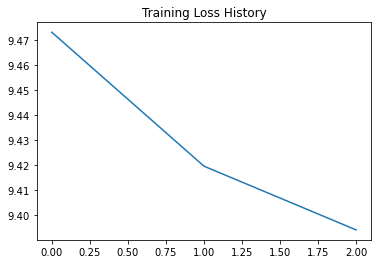

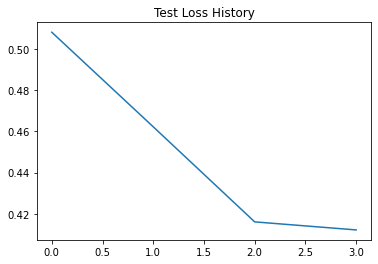

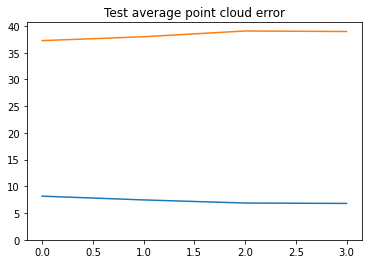

Training finished. Elapsed time: 48.692617893218994
Training loss: 9.394003472561877
Test loss: 0.41221343286195494
Test average point cloud error: 6.8048624992370605
Test average max point cloud error: 38.96714401245117
Test  max point cloud error: 50.56924819946289


In [8]:
### Training

# Generators
training_params = {'batch_size': 100,
          'shuffle': True,
          'max_epochs' : 3,
          'learning_rate' : .1,
          'momentum': .9}

train_model(model, training_data, test_data, test_data_pointcloud, training_params)

## Display some predictions

We compare the initial guess for the particle with the ground truth and the prediction after the optimization.

Here we show the tomographic projection of the particles (without the CTF).

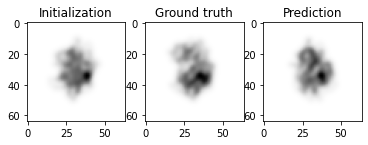

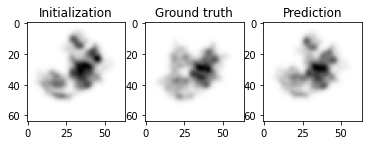

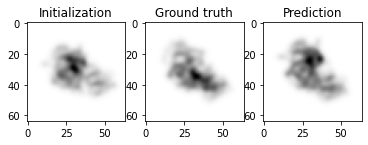

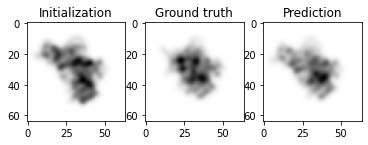

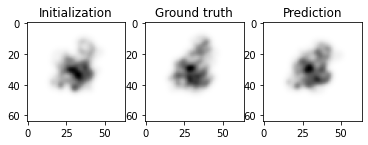

In [9]:
# Let's compare the tomographic projections of the predicted structures 
# with the ground truth and the initialization.
from tools.plots import disp_img_validation

preds_imgs = model.pred_images_without_CTF(test_inputs[:5, :-1]).detach()

original_imgs = clean_imgs_no_CTF[test_idx]

disp_img_validation(preds_init_imgs, original_imgs, preds_imgs)

#### Predictions of the atomic structures

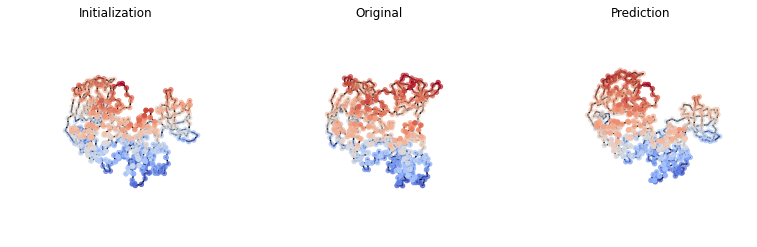

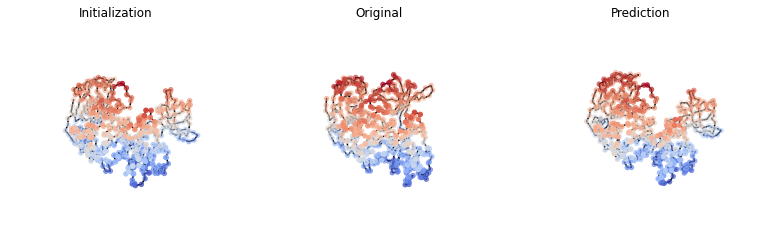

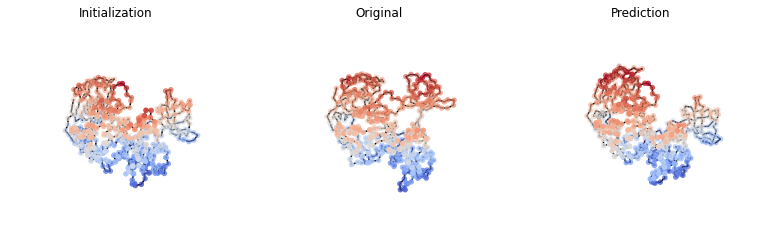

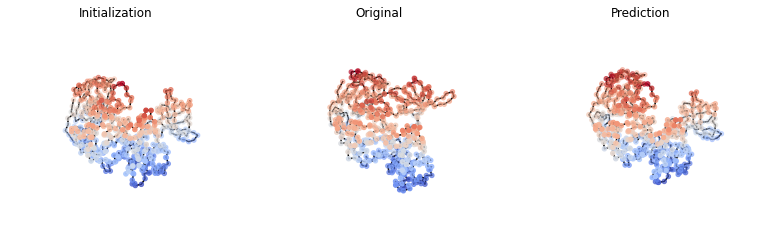

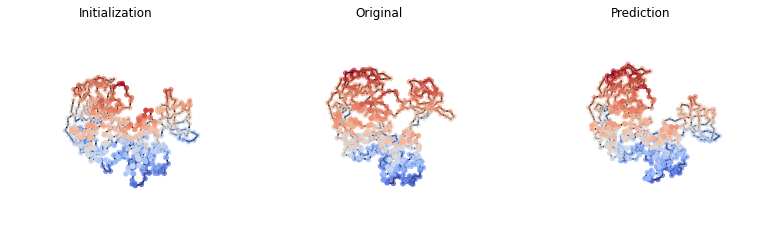

In [10]:
# Let's compare the predicted structures 
# with the ground truth and the initialization.

from tools.plots import disp_struct_validation

struct_preds = model.forward_disc_curve(test_inputs_plot[:5]).detach()

orientation_diffs_data_plot = view_angle_plot - structure_data.orientation
struct_ground_truth = structure_data.discrete_curves(orientation_diffs_data_plot).detach()[test_idx][:5]

disp_struct_validation(struct_init, struct_ground_truth, struct_preds)